In [1]:
!which python
!python --version
!pip install xgboost
!pip install optuna
!pip install tensorflow
!pip install -U scikit-learn

/opt/anaconda3/bin/python
Python 3.12.2


In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import sklearn 
import sklearn.metrics 
import xgboost as xgb
import optuna
import tensorflow as tf
import sklearn.model_selection
import sklearn.metrics
import netron
import seaborn as sns


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam, SGD, Nadam, RMSprop 
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from sklearn.metrics import confusion_matrix


In [3]:
!ls

Assignment_1.ipynb       best_model.keras         train.csv
Assignment_Template.docx model.png
ReadMe.pdf               test.csv


In [4]:
train = np.loadtxt('train.csv', delimiter=',')
test = np.loadtxt('test.csv', delimiter=',')

# Separate the first column as the target variable and the rest as features
Ytrain = train[:, 0]   # First column (target values)
Xtrain = train[:, 1:]  # All columns except the first (features)
Ytest = test[:, 0]   # First column (target values)
Xtest = test[:, 1:]  # All columns except the first (features)


In [5]:
print('samples:',len(Xtrain), '....features:',len(Xtrain[1]))

samples: 60000 ....features: 784


In [6]:
# Split the data
X_train, X_valid, Y_train, Y_valid = train_test_split(Xtrain, Ytrain, test_size=0.2, random_state=42)

In [7]:
'''
Build NN models from a params list
Make sure to run this code block before the code blocks after

Takes in a key:value pair of params for model
'''
def build_best_model(best_params):
    num_layers = best_params['num_layers'] 
    
    model = Sequential()
    model.add(Input(shape=(784,))) 
    model.add(Dense(best_params['neurons_layer_0'],  activation=best_params['activation_layer_0']))
    model.add(BatchNormalization())
    
    for i in range(1, num_layers):
        model.add(Dense(best_params[f'neurons_layer_{i}'], activation=best_params[f'activation_layer_{i}']))
        if best_params[f'dropout_rate_layer_{i}'] > 0:
            model.add(Dropout(best_params[f'dropout_rate_layer_{i}']))
        model.add(BatchNormalization())
    
    # This layers produces a prob. as output
    model.add(Dense(10, activation='softmax'))
    
    
    if best_params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=best_params['adam_learning_rate'])
    elif best_params['optimizer'] == 'rmsprop':
        optimizer = RMSprop(learning_rate=best_params['rmsprop_learning_rate'])
    else :
        optimizer = Nadam(learning_rate=best_params['nadam_learning_rate'])
    
    
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [ ]:
'''
Finding best params for NN model using optuna
Trial values can be adjusted to tune the model
    layers, neurons, activation function, dropout, and learning rate
'''
def objective(trial):

    num_layers = trial.suggest_int('num_layers', 3, 6)

    model = Sequential()
    model.add(Input(shape=(784,))) 
    model.add(Dense(trial.suggest_categorical('neurons_layer_0', [256,512,1024]),
                    activation=trial.suggest_categorical('activation_layer_0', ['tanh','elu','relu'])))
    model.add(BatchNormalization())

    for i in range(1, num_layers):
        # Specify hyperparameters for each layer
        num_neurons = trial.suggest_categorical(f'neurons_layer_{i}', [32, 64, 128, 256])
        activation = trial.suggest_categorical(f'activation_layer_{i}', ['tanh','elu','relu'])
        dropout_rate = trial.suggest_float(f'dropout_rate_layer_{i}', 0.2, 0.8)

        model.add(Dense(num_neurons, activation=activation))
        model.add(Dropout(dropout_rate))
        model.add(BatchNormalization())

    # This layers produces a prob. across all classes as output
    model.add(Dense(10, activation='softmax'))

    optimizer_options = trial.suggest_categorical('optimizer', ['adam', 'rmsprop', 'nadam'])
    if optimizer_options == 'rmsprop':
        learning_rate = trial.suggest_float('rmsprop_learning_rate', 1e-4, 1e-1, log=True)
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_options == 'nadam':
        learning_rate1 = trial.suggest_float('nadam_learning_rate', 1e-4, 1e-1, log=True)
        optimizer = Nadam(learning_rate=learning_rate1)
    else:
        learning_rate2 = trial.suggest_float('adam_learning_rate', 1e-4, 1e-1, log=True)
        optimizer = Adam(learning_rate=learning_rate2)
    
    # Compilation and training
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, mode='min')
    model.fit(X_train, Y_train, epochs=150, batch_size=500, verbose=0, validation_data = [X_valid,Y_valid], callbacks=[early_stopping])
    metrics = model.evaluate(X_valid, Y_valid)
    return metrics[1] #returns loss

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15, n_jobs=1)  

# Output the optimization results
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

In [8]:
'''
Manually record best trials with optuna
Can be added as a list to best_params for further testing or ensemble 
'''

# optimize on validation loss

#Model 1 finished with value: 0.08791228383779526 and parameters: {'num_layers': 4, 'neurons_layer_0': 512, 'activation_layer_0': 'elu', 'neurons_layer_1': 128, 'activation_layer_1': 'elu', 'dropout_rate_layer_1': 0.2829448352285742, 'neurons_layer_2': 64, 'activation_layer_2': 'elu', 'dropout_rate_layer_2': 0.2655066757643257, 'neurons_layer_3': 128, 'activation_layer_3': 'tanh', 'dropout_rate_layer_3': 0.25614728432047723, 'optimizer': 'nadam', 'nadam_learning_rate': 0.0008810946354147501}
#Model 2 finished with value: 1.4006129503250122 and parameters: {'num_layers': 6, 'neurons_layer_0': 512, 'activation_layer_0': 'tanh', 'neurons_layer_1': 128, 'activation_layer_1': 'relu', 'dropout_rate_layer_1': 0.6776023877009132, 'neurons_layer_2': 128, 'activation_layer_2': 'relu', 'dropout_rate_layer_2': 0.3016538976228721, 'neurons_layer_3': 128, 'activation_layer_3': 'relu', 'dropout_rate_layer_3': 0.3283446766790587, 'neurons_layer_4': 32, 'activation_layer_4': 'elu', 'dropout_rate_layer_4': 0.6961107384945519, 'neurons_layer_5': 32, 'activation_layer_5': 'tanh', 'dropout_rate_layer_5': 0.6014602123112479, 'optimizer': 'nadam', 'nadam_learning_rate': 0.07058159527362692}
#Model 3 finished with value: 0.0703088566660881 and parameters: {'num_layers': 3, 'neurons_layer_0': 1024, 'activation_layer_0': 'relu', 'neurons_layer_1': 32, 'activation_layer_1': 'relu', 'dropout_rate_layer_1': 0.30263320061329924, 'neurons_layer_2': 128, 'activation_layer_2': 'relu', 'dropout_rate_layer_2': 0.7111299754614744, 'optimizer': 'nadam', 'nadam_learning_rate': 0.0003554218948090363}

# optimize on validation accuracy 
#Model 4 finished with value: 0.9810000061988831 and parameters: {'num_layers': 3, 'neurons_layer_0': 1024, 'activation_layer_0': 'elu', 'neurons_layer_1': 256, 'activation_layer_1': 'relu', 'dropout_rate_layer_1': 0.470420426624745, 'neurons_layer_2': 128, 'activation_layer_2': 'tanh', 'dropout_rate_layer_2': 0.5127274905305742, 'optimizer': 'adam', 'adam_learning_rate': 0.00010760129590833543}. 
#Model 5 finished with value: 0.981249988079071 and parameters: {'num_layers': 3, 'neurons_layer_0': 1024, 'activation_layer_0': 'relu', 'neurons_layer_1': 256, 'activation_layer_1': 'relu', 'dropout_rate_layer_1': 0.44278429049160156, 'neurons_layer_2': 256, 'activation_layer_2': 'elu', 'dropout_rate_layer_2': 0.5002463983460863, 'optimizer': 'nadam', 'nadam_learning_rate': 0.0001020782066720838}


best_params = {'num_layers': 3, 'neurons_layer_0': 1024, 'activation_layer_0': 'elu', 'neurons_layer_1': 256, 'activation_layer_1': 'relu', 'dropout_rate_layer_1': 0.470420426624745, 'neurons_layer_2': 128, 'activation_layer_2': 'tanh', 'dropout_rate_layer_2': 0.5127274905305742, 'optimizer': 'adam', 'adam_learning_rate': 0.00010760129590833543}

In [9]:
# Build and train the model
best_model = build_best_model(best_params)
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
history = best_model.fit(X_train, Y_train, epochs=150, batch_size=500, verbose=0, validation_data=[X_valid,Y_valid], callbacks=[early_stopping])

# Evaluate the model on training data
evaluation_train = best_model.evaluate(X_train, Y_train)
print(f"Train Loss: {evaluation_train[0]}, Train Accuracy: {evaluation_train[1]}")

# Evaluate the model on validation data split from train data
evaluation_valid = best_model.evaluate(X_valid, Y_valid)
print(f"Validation Loss: {evaluation_valid[0]}, Validation Accuracy: {evaluation_valid[1]}")

# Evaluate the model on original held out test data
evaluation_test = best_model.evaluate(Xtest, Ytest)
print(f"Test Loss: {evaluation_test[0]}, Test Accuracy: {evaluation_test[1]}")

# Make predictions on the train data
predictions_train = best_model.predict(X_train)
predicted_classes_train = predictions_train.argmax(axis=-1)  # Picks highest prob from softmax

# Make predictions on the validation data
predictions_valid = best_model.predict(X_valid)
predicted_classes_valid = predictions_valid.argmax(axis=-1)  # Picks highest prob from softmax

# Make predictions on the test data
predictions_test = best_model.predict(Xtest)
predicted_classes_test = predictions_test.argmax(axis=-1)  # Picks highest prob from softmax


# Compute metrics for training data
accuracy_train = accuracy_score(Y_train, predicted_classes_train)
precision_train = precision_score(Y_train, predicted_classes_train, average='weighted')
recall_train = recall_score(Y_train, predicted_classes_train, average='weighted')
f1_train = f1_score(Y_train, predicted_classes_train, average='weighted')

# Print metrics for training data
print(f"Train Accuracy: {accuracy_train}")
print(f"Train Precision: {precision_train}")
print(f"Train Recall: {recall_train}")
print(f"Train F1 Score: {f1_train}")

# Compute metrics for validation data
accuracy_valid = accuracy_score(Y_valid, predicted_classes_valid)
precision_valid = precision_score(Y_valid, predicted_classes_valid, average='weighted')
recall_valid = recall_score(Y_valid, predicted_classes_valid, average='weighted')
f1_valid = f1_score(Y_valid, predicted_classes_valid, average='weighted')

# Print metrics for validation data
print(f"Validation Accuracy: {accuracy_valid}")
print(f"Validation Precision: {precision_valid}")
print(f"Validation Recall: {recall_valid}")
print(f"Validation F1 Score: {f1_valid}")

# Compute metrics for test data
accuracy_test = accuracy_score(Ytest, predicted_classes_test)
precision_test = precision_score(Ytest, predicted_classes_test, average='weighted')
recall_test = recall_score(Ytest, predicted_classes_test, average='weighted')
f1_test = f1_score(Ytest, predicted_classes_test, average='weighted')

# Print metrics for test data
print(f"Test Accuracy: {accuracy_test}")
print(f"Test Precision: {precision_test}")
print(f"Test Recall: {recall_test}")
print(f"Test F1 Score: {f1_test}")


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9994 - loss: 0.0039
Train Loss: 0.0038810456171631813, Train Accuracy: 0.9994375109672546
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9797 - loss: 0.0738
Validation Loss: 0.07396168261766434, Validation Accuracy: 0.9796666502952576
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9763 - loss: 0.0841
Test Loss: 0.06999727338552475, Test Accuracy: 0.9804999828338623
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Train Accuracy: 0.9994375
Train Precision: 0.9994375741128112
Train Recall: 0.9994375
Train F1 Score: 0.9994374830252942
Validation Accuracy: 0.9796666666666667
Validation Precision: 0.9797084270312856
Validation Recall: 0.9796666666666667
Validation F1 Score: 0.9796646414512834
Test Accuracy: 0.9805
Test Precision: 0.9805112758343711
Test Recall: 0.9805
Test F1 Score: 0.9804951505787806


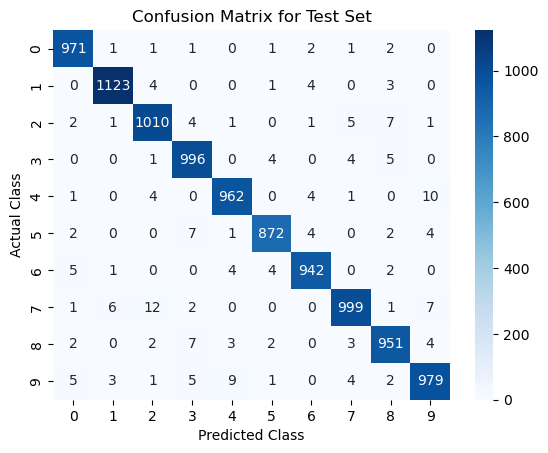

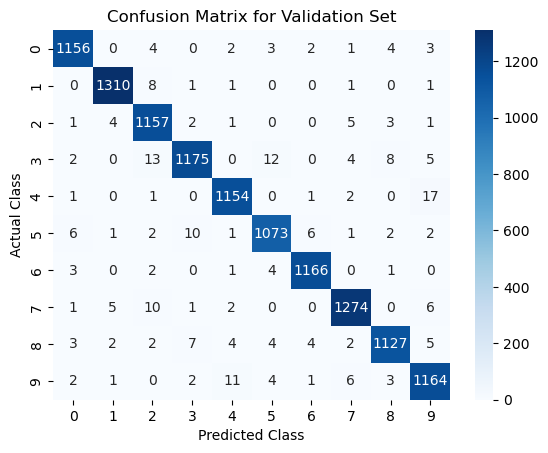

In [10]:
# Confusion matrix for test set
cm_test = confusion_matrix(Ytest, predicted_classes_test)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Test Set')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

# Confusion matrix for validation set
cm_valid = confusion_matrix(Y_valid, predicted_classes_valid)
sns.heatmap(cm_valid, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Validation Set')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

In [11]:
best_model.save('best_model.keras')
# Launch Netron to view the saved model in your browser
netron.start('best_model.keras')

Serving 'best_model.keras' at http://localhost:8080


('localhost', 8080)

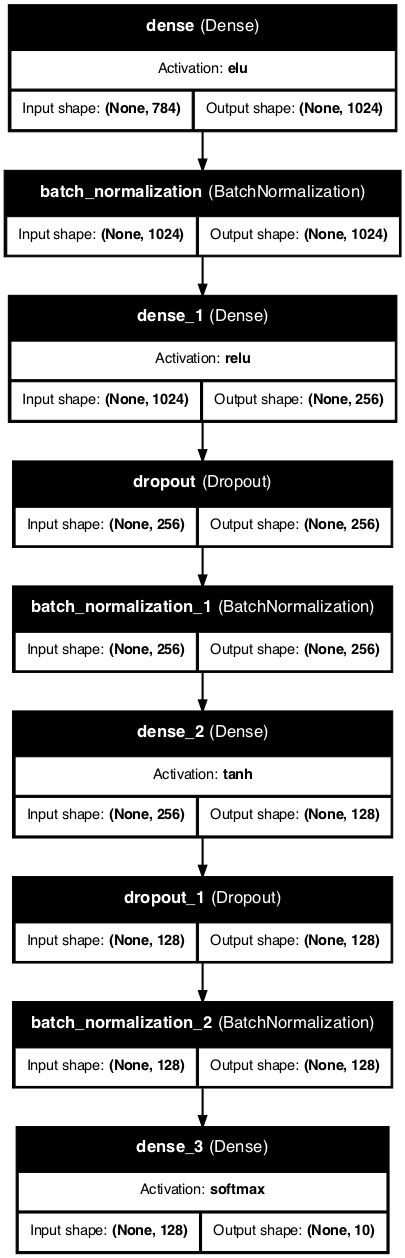

In [12]:
plot_model(
    best_model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=75,
    show_layer_activations=True,
    show_trainable=False,
)


In [13]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1024)           │       803,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,312,544 (12.64 MB)

 Trainable params: 1,103,242 (4.21 MB)

 Non-trainable params: 2,816 (11.00 KB)

 Optimizer params: 2,206,486 (8.42 MB)

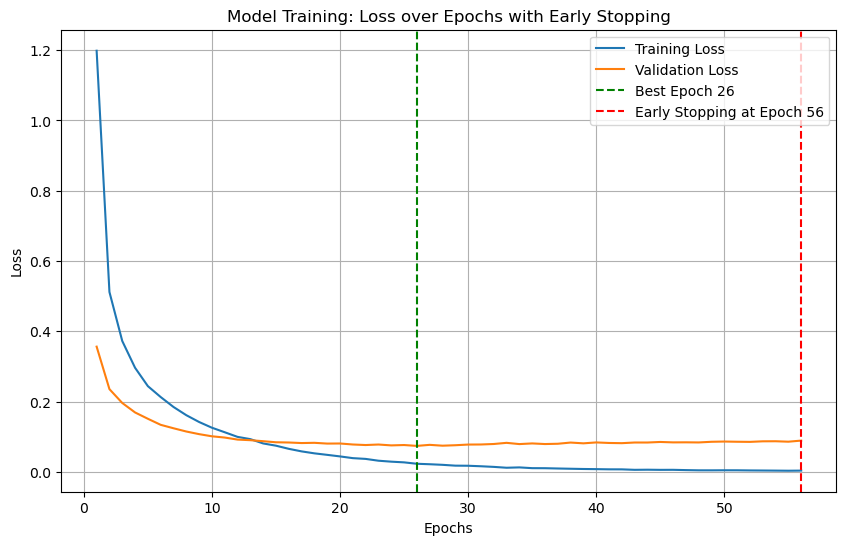

In [14]:
# Extract loss and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Get the epoch where the best validation loss occurred
best_epoch = early_stopping.stopped_epoch - early_stopping.patience + 1

# Plot training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')

# Add vertical line at the best epoch and at the stopping epoch
plt.axvline(x=best_epoch, color='g', linestyle='--', label=f'Best Epoch {best_epoch}')
plt.axvline(x=early_stopping.stopped_epoch + 1, color='r', linestyle='--', label=f'Early Stopping at Epoch {early_stopping.stopped_epoch + 1}')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Training: Loss over Epochs with Early Stopping')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()